In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

!pip install keras
!pip install keras-vis
!pip install --upgrade keras-vis
!pip install Pillow
!git clone https://github.com/Liz-30/PERROS-Y-GATOS.git
# Restore the original print function
from builtins import print as print_function

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout # Import convolutional layers directly from tensorflow.keras.layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from collections.abc import Iterable # Import Iterable from collections.abc

fatal: destination path 'PERROS-Y-GATOS' already exists and is not an empty directory.


In [45]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

def visualize_activation(model, layer_name, input_image):
    layer = model.get_layer(name=layer_name)
    activation_model = Model(inputs=model.input, outputs=layer.output)
    activations = activation_model.predict(input_image)
    n_filters = activations.shape[-1]
    n_cols = 8
    n_rows = int(np.ceil(n_filters / n_cols))
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()

In [46]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

##DEFINICIÓN DE MODELO

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
!git clone https://github.com/Liz-30/PERROS-Y-GATOS.git ##VERIFICAR
!ls /content/PERROS-Y-GATOS/Perros_Gatos/'Tess'

fatal: destination path 'PERROS-Y-GATOS' already exists and is not an empty directory.
ls: cannot access '/content/PERROS-Y-GATOS/Perros_Gatos/Tess': No such file or directory


##GENERADOR DE DATOS


In [53]:
base_dir = '/content/PERROS-Y-GATOS/Perros_Gatos'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

# Check if the generators are yielding data
print("Number of training batches:", len(train_generator))
print("Number of validation batches:", len(validation_generator))

# Try to load a batch from each generator
try:
    train_batch = next(train_generator)
    print("Successfully loaded a training batch.")
except StopIteration:
    print("Training generator is empty.")

try:
    validation_batch = next(validation_generator)
    print("Successfully loaded a validation batch.")
except StopIteration:
    print("Validation generator is empty.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/PERROS-Y-GATOS/Perros_Gatos/train'

In [54]:
val_batch = next(validation_generator)
print(val_batch[0].shape, val_batch[1].shape)  # Debe imprimir las formas de las imágenes y las etiquetas

(20, 150, 150, 3) (20,)


##ENTRENAMIENTO DEL MODELO


In [ ]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=validation_generator, validation_steps=15, verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 641ms/step - accuracy: 0.4929 - loss: 0.7300 - val_accuracy: 0.5033 - val_loss: 0.6921
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 672ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.5233 - val_loss: 0.6890
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 635ms/step - accuracy: 0.5077 - loss: 0.6926 - val_accuracy: 0.4933 - val_loss: 0.6929
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 637ms/step - accuracy: 0.5445 - loss: 0.6898 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 617ms/step - accuracy: 0.5225 - loss: 0.6927 - val_accuracy: 0.4767 - val_loss: 0.7025
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 654ms/step - accuracy: 0.5220 - loss: 0.6894 - val_accuracy: 0.5400 - val_loss: 0.6812
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 615ms/step - accuracy: 0.5798 - loss: 0.6764 - val_accuracy: 0.5650 - val_loss: 0.6753
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 633ms/step - accuracy: 0.5994 - loss: 0

In [55]:
model.save('model.h5')
save_history(history, 'history.bin')

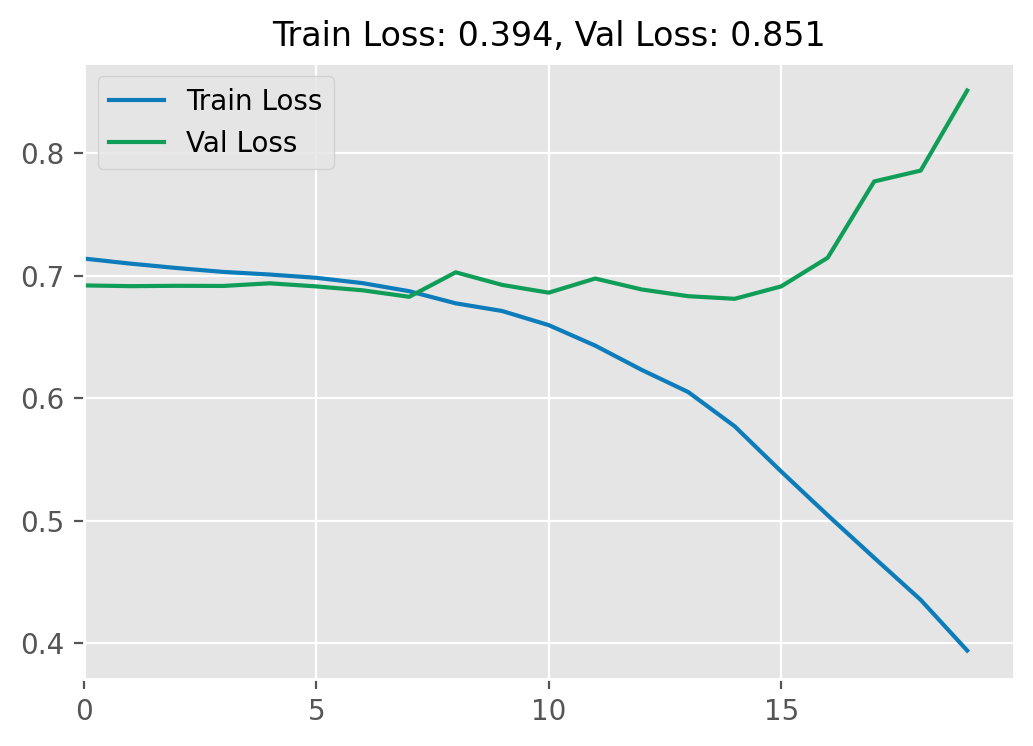

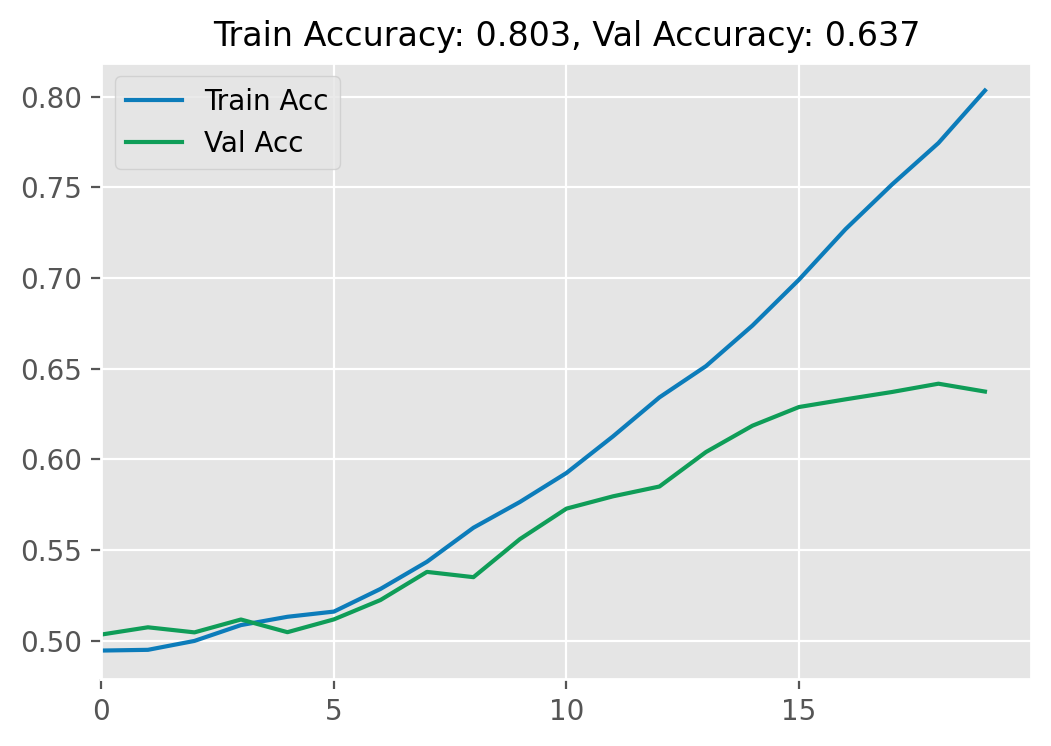

In [56]:
history = load_history('history.bin')
plot_compare(history)

##ARGUMENTACIÓN DE DATOS


In [57]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [58]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=20,
                                      validation_data=validation_generator, validation_steps=15, verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/PERROS-Y-GATOS/Perros_Gatos/train'

In [60]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

NameError: name 'history_aug' is not defined

In [61]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

FileNotFoundError: [Errno 2] No such file or directory: 'history_aug.bin'

##VISUALIZANDO RESULTADOS

In [62]:
img_path = '/content/PERROS-Y-GATOS/Perros_Gatos/Tess/Gatos/cat.1057.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/PERROS-Y-GATOS/Perros_Gatos/Tess/Gatos/cat.1057.jpg'

##IMAGEN

In [63]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

NameError: name 'img_tensor' is not defined

In [64]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

##RESULTADO OCULTO

In [65]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

NameError: name 'img_tensor' is not defined

In [66]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

NameError: name 'img_tensor' is not defined